# Enhanced Feature Engineering (3 Seasons + Contextual Features)

This notebook creates an enhanced feature set with:

**Previous features (from notebook 05):**
- Rolling averages (last 3, last 5 games) for PTS, REB, AST, MIN
- Usage stats rolling averages (FGA, FTA, FG3A)
- Efficiency rolling averages (FG_PCT)

**New contextual features:**
- Opponent defensive rating (season-to-date)
- Opponent offensive rating (season-to-date)
- Opponent pace (season-to-date)
- Home/away indicator
- Rest days since last game
- Back-to-back games flag

**Data scope:** ~10,000-15,000 games across 3 seasons (2022-2025)

**Train/Val/Test split:**
- Train: 2022-10-01 to 2024-07-31 (~70% of data)
- Validation: 2024-08-01 to 2024-12-31 (~15% of data)
- Test: 2025-01-01 to 2025-04-15 (~15% of data)

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Setup complete!")

Setup complete!


## Step 1: Load Enhanced Dataset

In [2]:
# Load enhanced dataset from notebook 07
df = pd.read_parquet('../data/raw/player_gamelogs_enhanced_2022-2025.parquet')

print(f"Enhanced dataset loaded:")
print(f"  Records: {len(df):,}")
print(f"  Players: {df['PLAYER_ID'].nunique()}")
print(f"  Date range: {df['GAME_DATE'].min().date()} to {df['GAME_DATE'].max().date()}")
print(f"  Seasons: {sorted(df['SEASON'].unique())}")

print(f"\nGames per season:")
print(df.groupby('SEASON').size())

print(f"\nContextual features available:")
contextual_cols = ['IS_HOME', 'REST_DAYS', 'IS_BACK_TO_BACK', 'OPP_DEF_RATING', 'OPP_OFF_RATING', 'OPP_PACE']
for col in contextual_cols:
    if col in df.columns:
        coverage = df[col].notna().mean() * 100
        print(f"  ✓ {col:<20} ({coverage:.1f}% coverage)")
    else:
        print(f"  ✗ {col:<20} (missing)")

Enhanced dataset loaded:
  Records: 23,925
  Players: 120
  Date range: 2022-10-18 to 2025-04-13
  Seasons: ['2022-23', '2023-24', '2024-25']

Games per season:
SEASON
2022-23    7585
2023-24    8826
2024-25    7514
dtype: int64

Contextual features available:
  ✓ IS_HOME              (100.0% coverage)
  ✓ REST_DAYS            (99.5% coverage)
  ✓ IS_BACK_TO_BACK      (100.0% coverage)
  ✓ OPP_DEF_RATING       (100.0% coverage)
  ✓ OPP_OFF_RATING       (100.0% coverage)
  ✓ OPP_PACE             (100.0% coverage)


## Step 2: Add Rolling Average Features (Leakage-Safe)

Same approach as notebook 05, but applied to the larger dataset.

In [3]:
def add_enhanced_rolling_features(df, windows=[3, 5]):
    """Add enhanced rolling average features with usage stats (leakage-safe)."""
    
    features = []
    
    for player_id in df['PLAYER_ID'].unique():
        player_df = df[df['PLAYER_ID'] == player_id].copy()
        player_df = player_df.sort_values('GAME_DATE')
        
        for window in windows:
            # Performance rolling averages (LEAKAGE-SAFE: shift(1) then rolling)
            player_df[f'pts_last_{window}'] = player_df['PTS'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'reb_last_{window}'] = player_df['REB'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'ast_last_{window}'] = player_df['AST'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'min_last_{window}'] = player_df['MIN'].shift(1).rolling(window, min_periods=1).mean()
            
            # Usage rolling averages
            player_df[f'fga_last_{window}'] = player_df['FGA'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'fta_last_{window}'] = player_df['FTA'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'fg3a_last_{window}'] = player_df['FG3A'].shift(1).rolling(window, min_periods=1).mean()
            
            # Efficiency rolling averages (handle NaN in FG_PCT)
            fg_pct_rolling = player_df['FG_PCT'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'fg_pct_last_{window}'] = fg_pct_rolling.fillna(player_df['FG_PCT'].mean())
        
        # Games played counter (for each player)
        player_df['games_played'] = range(len(player_df))
        
        features.append(player_df)
    
    return pd.concat(features, ignore_index=True)

print("Adding rolling features (this may take 1-2 minutes for large dataset)...")
df_enhanced = add_enhanced_rolling_features(df)

print("\n✓ Rolling features added")
print(f"  Total columns: {len(df_enhanced.columns)}")

# List new rolling feature columns
rolling_cols = [col for col in df_enhanced.columns if '_last_' in col or col == 'games_played']
print(f"  Rolling features: {len(rolling_cols)}")
print(f"\nRolling feature list:")
for i, col in enumerate(rolling_cols, 1):
    print(f"  {i:2}. {col}")

Adding rolling features (this may take 1-2 minutes for large dataset)...

✓ Rolling features added
  Total columns: 59
  Rolling features: 17

Rolling feature list:
   1. pts_last_3
   2. reb_last_3
   3. ast_last_3
   4. min_last_3
   5. fga_last_3
   6. fta_last_3
   7. fg3a_last_3
   8. fg_pct_last_3
   9. pts_last_5
  10. reb_last_5
  11. ast_last_5
  12. min_last_5
  13. fga_last_5
  14. fta_last_5
  15. fg3a_last_5
  16. fg_pct_last_5
  17. games_played


## Step 3: Prepare Final Feature Set

In [4]:
# Define feature sets

# Original features (from notebook 05)
original_features = [
    'pts_last_3', 'pts_last_5',
    'reb_last_3', 'reb_last_5',
    'ast_last_3', 'ast_last_5',
    'min_last_3', 'min_last_5',
    'games_played'
]

# Enhanced features (usage + efficiency)
enhanced_features = [
    'fga_last_3', 'fga_last_5',
    'fta_last_3', 'fta_last_5',
    'fg3a_last_3', 'fg3a_last_5',
    'fg_pct_last_3', 'fg_pct_last_5'
]

# Contextual features (NEW!)
contextual_features = [
    'IS_HOME',
    'REST_DAYS',
    'IS_BACK_TO_BACK',
    'OPP_DEF_RATING',
    'OPP_OFF_RATING',
    'OPP_PACE'
]

# All features combined
all_features = original_features + enhanced_features + contextual_features

print("Feature sets defined:")
print(f"  Original features: {len(original_features)}")
print(f"  Enhanced features (usage): {len(enhanced_features)}")
print(f"  Contextual features (NEW): {len(contextual_features)}")
print(f"  Total features: {len(all_features)}")

# Check feature availability
print(f"\nFeature availability:")
for feat in all_features:
    if feat in df_enhanced.columns:
        coverage = df_enhanced[feat].notna().mean() * 100
        print(f"  ✓ {feat:<20} ({coverage:.1f}% non-null)")
    else:
        print(f"  ✗ {feat:<20} (MISSING)")

Feature sets defined:
  Original features: 9
  Enhanced features (usage): 8
  Contextual features (NEW): 6
  Total features: 23

Feature availability:
  ✓ pts_last_3           (99.5% non-null)
  ✓ pts_last_5           (99.5% non-null)
  ✓ reb_last_3           (99.5% non-null)
  ✓ reb_last_5           (99.5% non-null)
  ✓ ast_last_3           (99.5% non-null)
  ✓ ast_last_5           (99.5% non-null)
  ✓ min_last_3           (99.5% non-null)
  ✓ min_last_5           (99.5% non-null)
  ✓ games_played         (100.0% non-null)
  ✓ fga_last_3           (99.5% non-null)
  ✓ fga_last_5           (99.5% non-null)
  ✓ fta_last_3           (99.5% non-null)
  ✓ fta_last_5           (99.5% non-null)
  ✓ fg3a_last_3          (99.5% non-null)
  ✓ fg3a_last_5          (99.5% non-null)
  ✓ fg_pct_last_3        (100.0% non-null)
  ✓ fg_pct_last_5        (100.0% non-null)
  ✓ IS_HOME              (100.0% non-null)
  ✓ REST_DAYS            (99.5% non-null)
  ✓ IS_BACK_TO_BACK      (100.0% non-null)
  ✓ 

## Step 4: Clean and Prepare for Modeling

In [5]:
# Drop rows with NaN in target variables
df_clean = df_enhanced.dropna(subset=['PTS', 'REB', 'AST'])

print(f"Dropped rows with missing targets:")
print(f"  Before: {len(df_enhanced):,}")
print(f"  After: {len(df_clean):,}")
print(f"  Dropped: {len(df_enhanced) - len(df_clean):,}")

# Drop rows where player has < 5 prior games (insufficient history for rolling features)
df_clean = df_clean[df_clean['games_played'] >= 5]

print(f"\nDropped rows with insufficient history (< 5 games):")
print(f"  Remaining: {len(df_clean):,}")

# Fill NaN in contextual features with median (if any)
for feat in contextual_features:
    if feat in df_clean.columns:
        if df_clean[feat].isna().sum() > 0:
            median_val = df_clean[feat].median()
            df_clean[feat] = df_clean[feat].fillna(median_val)
            print(f"  Filled NaN in {feat} with median: {median_val:.2f}")

# Final check for NaN in features
print(f"\nFinal NaN check:")
nan_counts = df_clean[all_features].isna().sum()
if nan_counts.sum() > 0:
    print("  ⚠️  Some features still have NaN:")
    print(nan_counts[nan_counts > 0])
else:
    print("  ✓ No NaN values in feature set")

print(f"\nFinal dataset size: {len(df_clean):,} games")

Dropped rows with missing targets:
  Before: 23,925
  After: 23,925
  Dropped: 0

Dropped rows with insufficient history (< 5 games):
  Remaining: 23,325

Final NaN check:
  ✓ No NaN values in feature set

Final dataset size: 23,325 games


## Step 5: Create Train/Validation/Test Splits

**Time-based splits (NO SHUFFLING):**
- **Train:** 2022-10-01 to 2024-07-31 (~70%)
- **Validation:** 2024-08-01 to 2024-12-31 (~15%)
- **Test:** 2025-01-01 to 2025-04-15 (~15%)

In [6]:
# Define split dates
train_end = pd.Timestamp('2024-07-31')
val_end = pd.Timestamp('2024-12-31')

# Create splits
train = df_clean[df_clean['GAME_DATE'] <= train_end].copy()
val = df_clean[(df_clean['GAME_DATE'] > train_end) & (df_clean['GAME_DATE'] <= val_end)].copy()
test = df_clean[df_clean['GAME_DATE'] > val_end].copy()

print("="*70)
print("TRAIN/VALIDATION/TEST SPLITS (Time-Based)")
print("="*70)

print(f"\nTrain Set:")
print(f"  Date range: {train['GAME_DATE'].min().date()} to {train['GAME_DATE'].max().date()}")
print(f"  Games: {len(train):,} ({len(train)/len(df_clean)*100:.1f}%)")
print(f"  Players: {train['PLAYER_ID'].nunique()}")
print(f"  Seasons: {sorted(train['SEASON'].unique())}")

print(f"\nValidation Set:")
print(f"  Date range: {val['GAME_DATE'].min().date()} to {val['GAME_DATE'].max().date()}")
print(f"  Games: {len(val):,} ({len(val)/len(df_clean)*100:.1f}%)")
print(f"  Players: {val['PLAYER_ID'].nunique()}")
print(f"  Seasons: {sorted(val['SEASON'].unique())}")

print(f"\nTest Set:")
print(f"  Date range: {test['GAME_DATE'].min().date()} to {test['GAME_DATE'].max().date()}")
print(f"  Games: {len(test):,} ({len(test)/len(df_clean)*100:.1f}%)")
print(f"  Players: {test['PLAYER_ID'].nunique()}")
print(f"  Seasons: {sorted(test['SEASON'].unique())}")

print(f"\nTarget distributions (Train/Val/Test):")
for target in ['PTS', 'REB', 'AST']:
    train_mean = train[target].mean()
    val_mean = val[target].mean()
    test_mean = test[target].mean()
    print(f"  {target}: {train_mean:.1f} / {val_mean:.1f} / {test_mean:.1f}")

TRAIN/VALIDATION/TEST SPLITS (Time-Based)

Train Set:
  Date range: 2022-10-27 to 2024-04-14
  Games: 15,811 (67.8%)
  Players: 120
  Seasons: ['2022-23', '2023-24']

Validation Set:
  Date range: 2024-10-22 to 2024-12-31
  Games: 3,129 (13.4%)
  Players: 118
  Seasons: ['2024-25']

Test Set:
  Date range: 2025-01-01 to 2025-04-13
  Games: 4,385 (18.8%)
  Players: 117
  Seasons: ['2024-25']

Target distributions (Train/Val/Test):
  PTS: 17.3 / 16.8 / 17.1
  REB: 5.4 / 5.5 / 5.4
  AST: 3.9 / 3.9 / 4.0


## Step 6: Save Processed Dataset

In [7]:
# Add split indicator
df_clean['SPLIT'] = 'train'
df_clean.loc[df_clean['GAME_DATE'] > train_end, 'SPLIT'] = 'val'
df_clean.loc[df_clean['GAME_DATE'] > val_end, 'SPLIT'] = 'test'

# Save full processed dataset
output_path = '../data/processed/features_enhanced_3seasons.parquet'
df_clean.to_parquet(output_path)

print("="*70)
print("ENHANCED FEATURES SAVED")
print("="*70)

print(f"\nFile: {output_path}")
print(f"  Size: {df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"  Records: {len(df_clean):,}")
print(f"  Features: {len(all_features)}")

print(f"\nFeature categories:")
print(f"  Original (rolling): {len(original_features)}")
print(f"  Enhanced (usage): {len(enhanced_features)}")
print(f"  Contextual (opponent + game): {len(contextual_features)}")
print(f"  Total: {len(all_features)}")

print(f"\nData splits:")
print(df_clean['SPLIT'].value_counts())

print(f"\nSample data with new features:")
display_cols = ['GAME_DATE', 'PLAYER_ID', 'PTS', 'REB', 'AST', 'IS_HOME', 
                'REST_DAYS', 'OPP_DEF_RATING', 'pts_last_5', 'SPLIT']
display(df_clean[display_cols].head(20))

print(f"\n{'='*70}")
print("Ready for comprehensive ML exploration!")
print("Next: Run notebook 09 with enhanced features and larger dataset")
print(f"{'='*70}")

ENHANCED FEATURES SAVED

File: ../data/processed/features_enhanced_3seasons.parquet
  Size: 20.7 MB
  Records: 23,325
  Features: 23

Feature categories:
  Original (rolling): 9
  Enhanced (usage): 8
  Contextual (opponent + game): 6
  Total: 23

Data splits:
SPLIT
train    15811
test      4385
val       3129
Name: count, dtype: int64

Sample data with new features:


,GAME_DATE,PLAYER_ID,PTS,REB,AST,IS_HOME,REST_DAYS,OPP_DEF_RATING,pts_last_5,SPLIT
5,2022-10-30,2544,26,6,8,True,1.0,112.8,25.8,train
6,2022-11-02,2544,20,10,8,True,2.0,111.3,24.8,train
7,2022-11-04,2544,17,10,8,True,1.0,114.5,24.8,train
8,2022-11-06,2544,27,7,4,True,1.0,109.8,22.0,train
9,2022-11-09,2544,30,8,5,False,2.0,112.5,23.6,train
10,2022-11-25,2544,21,8,5,False,15.0,118.9,24.0,train
11,2022-11-26,2544,39,11,3,False,0.0,118.9,23.0,train
12,2022-11-28,2544,21,7,3,True,1.0,116.4,26.8,train
13,2022-11-30,2544,31,7,8,True,1.0,116.6,27.6,train
14,2022-12-02,2544,28,8,11,False,1.0,110.4,28.4,train



Ready for comprehensive ML exploration!
Next: Run notebook 09 with enhanced features and larger dataset


## Bonus: Quick Visualization of New Features

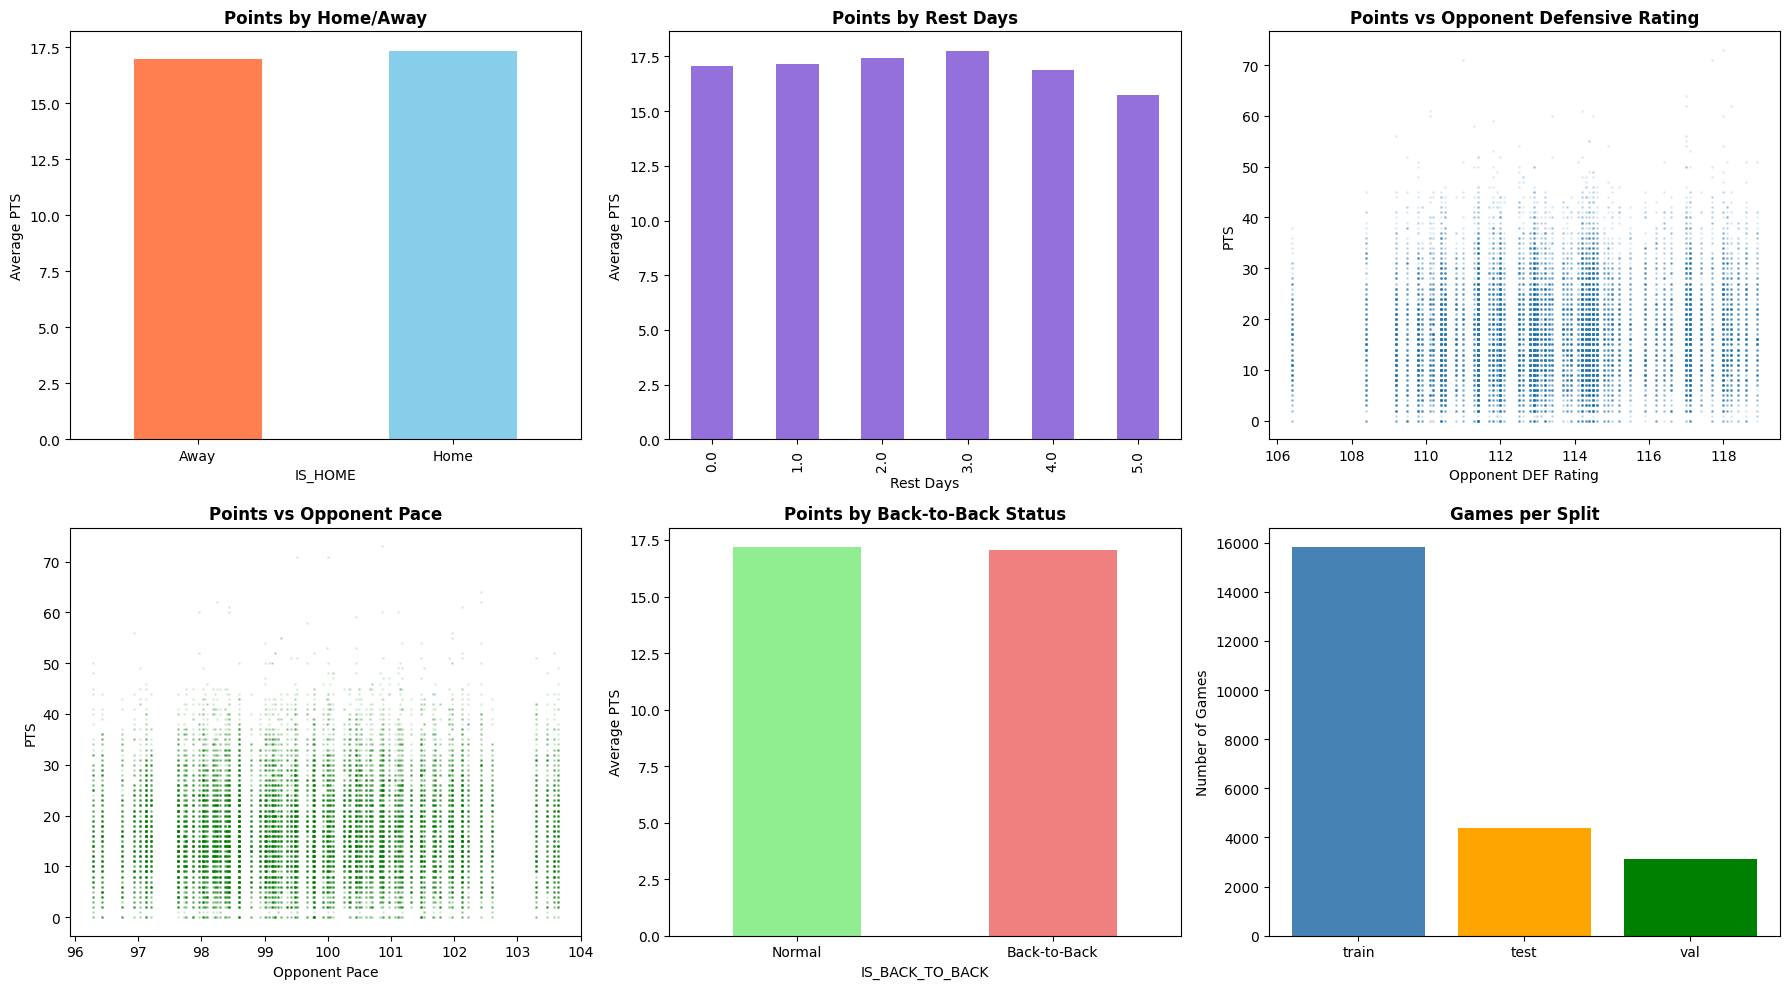


✓ Visualization saved to reports/figures/enhanced_features_visualization.png


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Home vs Away
df_clean.groupby('IS_HOME')['PTS'].mean().plot(kind='bar', ax=axes[0, 0], color=['coral', 'skyblue'])
axes[0, 0].set_title('Points by Home/Away', fontweight='bold')
axes[0, 0].set_ylabel('Average PTS')
axes[0, 0].set_xticklabels(['Away', 'Home'], rotation=0)

# Rest Days
df_clean[df_clean['REST_DAYS'] <= 5].groupby('REST_DAYS')['PTS'].mean().plot(kind='bar', ax=axes[0, 1], color='mediumpurple')
axes[0, 1].set_title('Points by Rest Days', fontweight='bold')
axes[0, 1].set_ylabel('Average PTS')
axes[0, 1].set_xlabel('Rest Days')

# Opponent Defensive Rating vs Points
axes[0, 2].scatter(df_clean['OPP_DEF_RATING'], df_clean['PTS'], alpha=0.1, s=1)
axes[0, 2].set_title('Points vs Opponent Defensive Rating', fontweight='bold')
axes[0, 2].set_xlabel('Opponent DEF Rating')
axes[0, 2].set_ylabel('PTS')

# Opponent Pace vs Points
axes[1, 0].scatter(df_clean['OPP_PACE'], df_clean['PTS'], alpha=0.1, s=1, color='green')
axes[1, 0].set_title('Points vs Opponent Pace', fontweight='bold')
axes[1, 0].set_xlabel('Opponent Pace')
axes[1, 0].set_ylabel('PTS')

# Back-to-back games
df_clean.groupby('IS_BACK_TO_BACK')['PTS'].mean().plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'lightcoral'])
axes[1, 1].set_title('Points by Back-to-Back Status', fontweight='bold')
axes[1, 1].set_ylabel('Average PTS')
axes[1, 1].set_xticklabels(['Normal', 'Back-to-Back'], rotation=0)

# Data distribution across splits
split_counts = df_clean['SPLIT'].value_counts()
axes[1, 2].bar(split_counts.index, split_counts.values, color=['steelblue', 'orange', 'green'])
axes[1, 2].set_title('Games per Split', fontweight='bold')
axes[1, 2].set_ylabel('Number of Games')

plt.tight_layout()
plt.savefig('../reports/figures/enhanced_features_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to reports/figures/enhanced_features_visualization.png")